In [97]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import re
import os

from scipy.io import readsav

from astropy.time import Time
from astropy.time import TimeDelta

from sunpy import timeseries as ts
from sunpy.net import attrs as a
from sunpy.net import Fido
from sunpy.time import parse_time, find_time

import pandas as pd

import goesxrs_temp as gtem #from Ian's functions

import Onsets_temp 

# Just setup plot fonts
plt.rcParams.update({'font.size': 18,'font.family':"sans-serif",\
                         'font.sans-serif':"Arial",'mathtext.default':"regular", 'axes.linewidth' : 2})

## Choosing a Flare to analyse

##### First choose a time range (day) to look at. Returns all flares of all classes detected during that period.

In [98]:
tsearch=a.Time("2010-11-05","2010-11-06") #First flare in paper
#tsearch=a.Time("2011-02-14","2011-02-15") #Second
#tsearch=a.Time("2012-05-14","2012-05-15") #Third
#tsearch=a.Time("2014-01-07","2014-01-08") #Fourth

#tsearch=a.Time("2011-08-09","2011-08-10") #First flare in poster
#tsearch=a.Time("2013-03-15","2013-03-16") #difficult flare
# tsearch=a.Time("2014-02-14","2014-02-15")
#tsearch = a.Time("2013-07-01", "2013-11-23")

#res = Fido.search(tsearch,a.hek.EventType("FL"), a.hek.FRM.Name == "SSW Latest Events")
res = Fido.search(tsearch,a.hek.EventType("FL"), a.hek.OBS.Observatory == "GOES")
fullres = res["hek"]

# Reduce the table down to just the info we want
day_res = fullres["event_starttime", "event_peaktime",
                        "event_endtime", "fl_goescls", "hpc_x", "hpc_y", "ar_noaanum"]
                        # More stuff that could be useful, Heliographic lat lon, and where from
                        # "event_endtime", "fl_goescls", "hpc_x", "hpc_y", "ar_noaanum", "hgc_x", "hgc_y", "frm_name"]

# print(day_res)

# Reformatting table for relevant info we want right now
day_res1 = fullres["event_starttime", "event_peaktime","event_endtime", "fl_goescls"]

print(f"Total Number of flares in period: {len(day_res1)}")
print("")
print("All flares that were detected during period: ")
print("")
print(day_res1)

Total Number of flares in period: 15

All flares that were detected during period: 

    event_starttime          event_peaktime     ... fl_goescls
----------------------- ----------------------- ... ----------
2010-11-04 23:30:00.000 2010-11-04 23:58:00.000 ...       M1.6
2010-11-04 23:30:00.000 2010-11-04 23:58:00.000 ...       M1.6
2010-11-05 00:48:00.000 2010-11-05 00:56:00.000 ...       C9.7
2010-11-05 03:15:00.000 2010-11-05 03:21:00.000 ...       B9.4
2010-11-05 06:27:00.000 2010-11-05 06:32:00.000 ...       B4.4
2010-11-05 06:27:00.000 2010-11-05 06:32:00.000 ...       B4.4
2010-11-05 08:03:00.000 2010-11-05 08:06:00.000 ...       B2.9
2010-11-05 08:51:00.000 2010-11-05 08:54:00.000 ...       B2.4
2010-11-05 10:21:00.000 2010-11-05 10:25:00.000 ...       B3.1
2010-11-05 11:09:00.000 2010-11-05 11:12:00.000 ...       B2.3
2010-11-05 12:43:00.000 2010-11-05 13:29:00.000 ...       M1.0
2010-11-05 18:37:00.000 2010-11-05 18:42:00.000 ...       B2.5
2010-11-05 20:08:00.000 2010-11-0

In [99]:
day_res1= day_res1[day_res1["event_starttime"].datetime >= Time("2010-11-05 00:00").datetime] 

#### Specify which flare we are wanting from the list above
Choose flare from row number

In [100]:
shrt_res = day_res1[10]["event_starttime", "event_peaktime","event_endtime", "fl_goescls"]

### Downloading GOES Data

We want to download this flare data if we haven't got it downloaded already. So we search our directory first, then we download if it is not present. (Set up for GOES-15 2s data)

In [101]:
def data_download(fl_data):
    print("{0} with peak time at: {1}".format(fl_data["fl_goescls"], fl_data["event_peaktime"]))

    # Want data for +/-10 mins of flare, using astopy time to do this (easier sunpy way?)
    fl_tstart=Time(fl_data["event_starttime"],scale='utc')-TimeDelta(10*60,format='sec')
    fl_tend=Time(fl_data["event_endtime"],scale='utc')+TimeDelta(10*60,format='sec')

    # Search and get the XRS data
    tflrange=a.Time(fl_tstart.iso, fl_tend.iso)
    print(tflrange)
    rg15 = Fido.search(tflrange, a.Instrument("XRS"), a.goes.SatelliteNumber(15))
    print(rg15)
    fg15 = Fido.fetch(rg15,path=data_dir)

In [102]:
data_dir = r"C:\Users\William\Documents\University\MastersProj\Data\Test\GOES15_2s" #data directory

#fetching the date 'YYYYMMDD' in string format fron the start date put in earlier
day_string = tsearch.start.datetime.date().strftime("%Y%m%d")
fl_path = os.path.join(data_dir,f'*g15*{day_string}*.nc')

#tries to load in the file, if it does not exist, it will download it.
try:
    ts.TimeSeries(fl_path, concatenate=True)
    print("File Exists")
except ValueError:
    print("File does not exist.... Downloading file....")
    data_download(shrt_res)

File Exists


#### Loading in the GOES data

Tasks:
1. Look at spacecraft flags (talk to Ian about this as cannot find on sunpy)
2. Plot over the start/end times of adjacent flares

In [103]:
#Load flare into time series
g15 = ts.TimeSeries(fl_path, concatenate=True)

# Extract out the time index and data channels for the full day
g_tims = g15.index
g_short = g15.quantity("xrsa").value 
g_long = g15.quantity("xrsb").value
g_short_flag = g15.quantity("xrsa_quality").value 
g_long_flag = g15.quantity("xrsb_quality").value 

# Create a Boolean mask where onset flag is equal to 1
mask_long = g_long_flag == 1
mask_short = g_short_flag == 1

# Set the corresponding values in g_short and g_long to NaN
g_short[mask_short]= np.nan
g_long[mask_long] = np.nan

In [104]:
from collections import Counter

counter = Counter(g_short)
most_frequent = counter.most_common()

print(most_frequent[0:10])

[(6.5242983e-10, 3542), (1.9686537e-09, 3483), (-6.6379396e-10, 3322), (3.2848775e-09, 3096), (-1.9800177e-09, 2674), (4.6011013e-09, 2673), (5.917325e-09, 2258), (7.233549e-09, 1947), (-3.2962415e-09, 1824), (8.5497724e-09, 1577)]


In [105]:

counter_long = Counter(g_long)
most_frequent_long = counter_long.most_common()

print(most_frequent_long[0:10])

[(2.384674e-07, 1542), (2.4223098e-07, 1477), (2.3470385e-07, 1355), (2.4599458e-07, 1309), (2.3094027e-07, 1124), (2.4975816e-07, 1025), (2.5352173e-07, 791), (2.2717668e-07, 748), (2.6857603e-07, 730), (2.572853e-07, 700)]


C:\Users\William\AppData\Local\Temp\ipykernel_17556\2057590249.py:18: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim([0,3e-5])


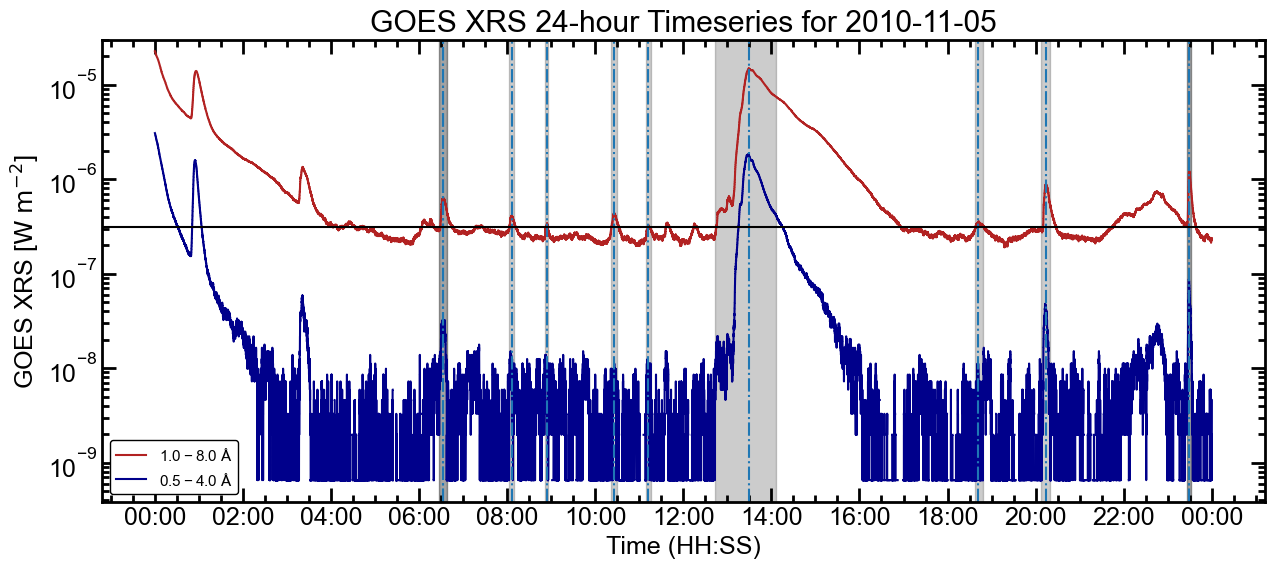

In [106]:
mask_short_mask = g_short <= 0 # Data dropouts at around 7e-10 and 0. Replace with NaN's
g_short[mask_short_mask] = np.nan 

fig,ax = plt.subplots(figsize=(15, 6))
plt.title("GOES XRS 24-hour Timeseries for 2010-11-05")
plt.plot(g_tims, g_long, drawstyle='steps-post', color = 'firebrick',  label = r"$1.0-8.0\;\AA$")
plt.plot(g_tims, g_short, drawstyle='steps-post', color = 'darkblue', label = r"$0.5-4.0\;\AA$")

for fl in day_res1[2:]:
    ax.axvline(parse_time(fl["event_peaktime"]).datetime,ls='-.')
    ax.axvspan(parse_time(fl["event_starttime"]).datetime, parse_time(fl["event_endtime"]).datetime,color='black',alpha=0.2)
# print(type(parse_time(fl["event_peaktime"]).datetime))

ax.axhline(np.median(g_long), color = 'black')
ax.set_ylabel("GOES XRS [$\mathrm{W\;m^{-2}}$] ")
ax.set_xlabel("Time (HH:SS)")
ax.set_yscale("log")
ax.set_ylim([0,3e-5])

myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.HourLocator(interval=2)
minorx= matplotlib.dates.MinuteLocator(interval=30)
ax.xaxis.set_major_locator(majorx)
ax.xaxis.set_minor_locator(minorx)
ax.xaxis.set_major_formatter(myFmt)
plt.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
plt.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
plt.tick_params(which='major', size=10, width=2, direction='in', right='on')
plt.tick_params(which='minor', size=5, width=2, direction='in', right='on')

plt.legend(fancybox = True, fontsize = 11, framealpha = 1, edgecolor = 'black')
plt.minorticks_on()
plt.show()

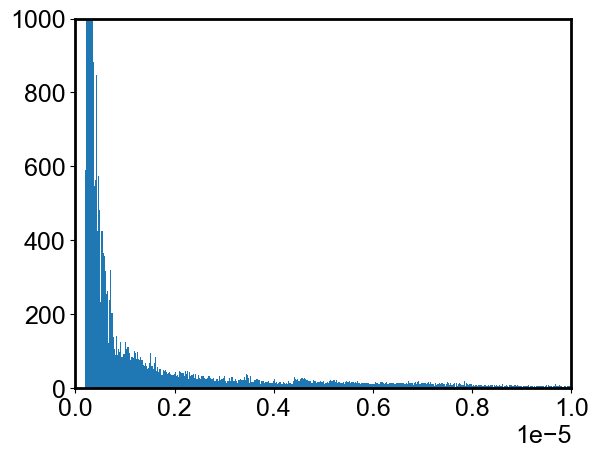

In [107]:
plt.hist(g_long, bins = 1000)
plt.ylim(0,1000)
plt.xlim(0,1e-5)
plt.show()

2010-11-05 20:08:00.000
2010-11-05 20:08:00.000
The peak long channel XRS flux is: 8.86e-07 Wm^-2


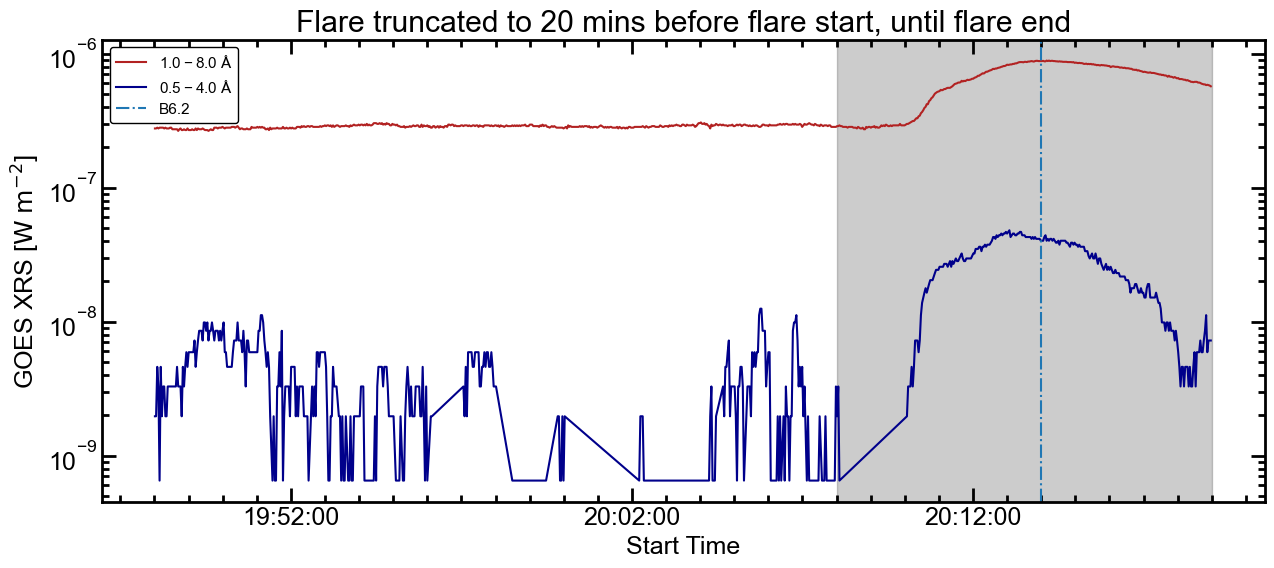

In [108]:
# truncate to time range interested: flare start - 2 hours until flare end (from flare list)
print((shrt_res["event_starttime"]))
print((Time(shrt_res["event_starttime"], scale = 'utc')))

gtstart=Time(shrt_res["event_starttime"],scale='utc')-TimeDelta(20*60,format='sec')
gtend=Time(shrt_res["event_endtime"],scale='utc')
trunc_range=a.Time(gtstart.iso,gtend.iso)
trunc_g15=g15.truncate(trunc_range.start.iso,trunc_range.end.iso)

# Extract out the time index and data channels
tg_tims = trunc_g15.index
tg_short = trunc_g15.quantity("xrsa").value
tg_long = trunc_g15.quantity("xrsb").value

# Calculating the peak flux (for new classification)
print(f"The peak long channel XRS flux is: {np.max(tg_long):.2e} Wm^-2")

# Smoothing short channel flux to 10s bins.
df_short = pd.Series(tg_short, index = pd.DatetimeIndex(tg_tims))
df_short = df_short.dropna()
df_short = df_short.drop(df_short[df_short <= 10**(-11)].index) #Removes NaN's and dropouts (under 10e-9)
# df_short_ds = df_short.resample('10S').mean() 

df_long = pd.Series(tg_long, index = pd.DatetimeIndex(tg_tims))
df_long = df_long.dropna()
df_long = df_long.drop(df_short[df_short <= 10**(-11)].index) #Removes NaN's and dropouts (under 10e-9)
#df_long_ds = df_short.resample('10S').mean() 

# Plotting
fig,ax = plt.subplots(figsize=(15, 6))
plt.title("Flare truncated to 20 mins before flare start, until flare end")
plt.plot(tg_tims, tg_long, color = 'firebrick',  label = r"$1.0-8.0\;\AA$")
plt.plot(df_short.index, df_short, color = 'darkblue', label = r"$0.5-4.0\;\AA$")

ax.axvline(parse_time(shrt_res["event_peaktime"]).datetime,ls='-.',label = shrt_res["fl_goescls"])
ax.axvspan(parse_time(shrt_res["event_starttime"]).datetime, parse_time(shrt_res["event_endtime"]).datetime,color='black',alpha=0.2)

ax.set_ylabel("GOES XRS [$\mathrm{W\;m^{-2}}$]")
ax.set_xlabel("Start Time")
ax.set_yscale("log")

myFmt = matplotlib.dates.DateFormatter('%H:%M:%S')
# majorx= matplotlib.dates.HourLocator(interval=0.5)
majorx= matplotlib.dates.MinuteLocator(interval=10)
minorx= matplotlib.dates.MinuteLocator(interval=1)
ax.xaxis.set_major_locator(majorx)
ax.xaxis.set_minor_locator(minorx)
ax.xaxis.set_major_formatter(myFmt)
ax.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax.tick_params(which='minor', size=5, width=2, direction='in', right='on')

ax.legend(fancybox = True, loc = "upper left", fontsize = 11, framealpha = 1, edgecolor = 'black')
plt.show()



### Background Subtraction
Now, we will later devise a more robust statistical method for subtracting the background, but here we are just going to use the preflare timings from Hock's method. We have downloaded a file with the timings but for future testing we can simply just calculate these: by truncating the data around the preflare phase, searching for a minimum and then centering a four-minute window around it.

_Tasks:_
1. Average the short channel flux to 10s and remove the bottoming out (with avergaing adjacent points) [DONE]
2. Use short channel flux instead of long for calculating  [DONE]
3. Create a flag for adjacent flares, possibly using a median average of the day (not counting anything over 10^(-5)).

_Testing Method 1:_ 
Use a similar method from hocks paper, with a bias to favour times closer to the flare, but probably a shorter window (30 secs to 2 mins).
1. Will start by just using the preceding 2 mins to the flare list start time.
2. Then can determine if its an acceptable background (using variance of the 2s series, 67% of points in one sigma of mean).
3. If not, we can try a time further back.
4. Repeat until 20mins previous, until we find an acceptable window.
5. If no window found, shorten window (increments of 5 seconds).
6. Repeat.
7. If still no window found for 30 second window length, flag data.

- For each try, record window length, location (in time series) and goodness of fit in a dataframe.

Alternative Techniques to look at:
- Look at time derivative of the short channel (want a nice flat spot)
- Look at FFT.
- Use scipy find_peaks to look at peaks and troughs (and plataeus).


In [109]:
# Function to truncate the data and output truncated data in 2s and 10s sampling

# Modified to have the first window begin at 5 mins after the posted start time.
def bck_truncate(startt = 60, endt = 0):
    bckstart=Time(shrt_res["event_starttime"],scale='utc')+TimeDelta(300,format='sec')-TimeDelta(startt,format='sec')
    bckend=Time(shrt_res["event_starttime"],scale='utc')+TimeDelta(300,format='sec')-TimeDelta(endt, format='sec')
    bcktime=a.Time(bckstart.iso,bckend.iso)
    bcktrunc_054=df_short.truncate(bcktime.start.iso,bcktime.end.iso)
    bcktrunc_18=df_long.truncate(bcktime.start.iso,bcktime.end.iso)
    
    return bcktime, bcktrunc_054, bcktrunc_18

The Percentage of Points within 1 standard deviation of the mean is: 86.5%
This is an acceptable dbackground


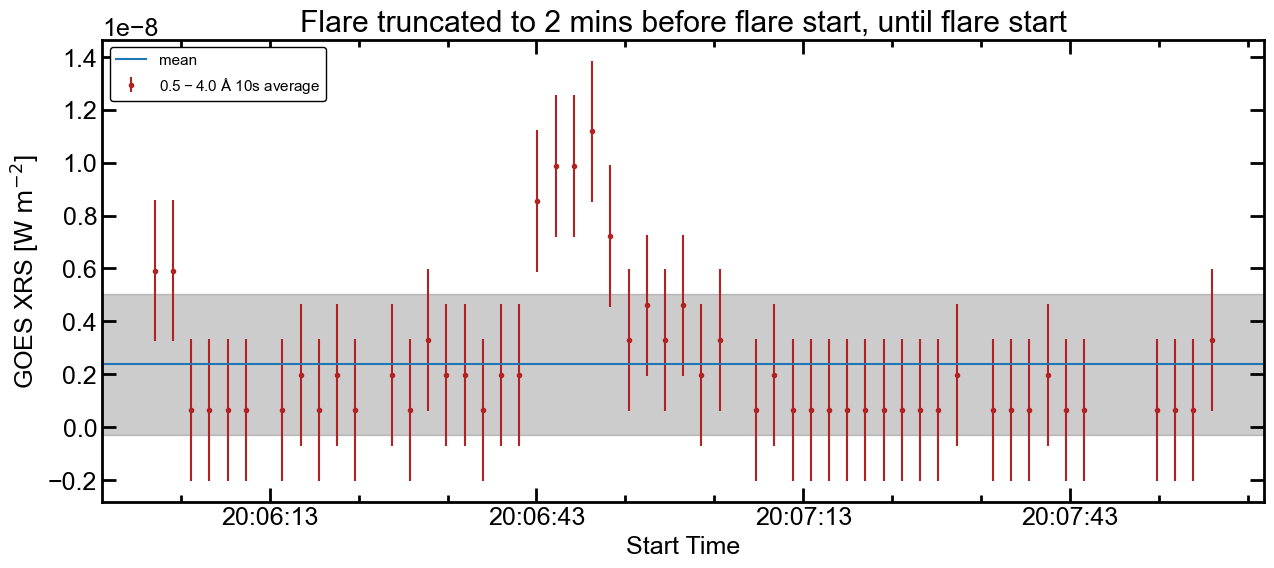

In [110]:
# Method 1a)
# Start by just looking at 2 minute window preceding the start time.

bckt, bcktrunc_054, bcktrunc_18 = bck_truncate(120+300, 300)

# Calculate mean, std of this window
bckmean = np.mean(bcktrunc_054)
bckstd = np.std(bcktrunc_054)

valid = []
for p in bcktrunc_054:
    if p < bckmean:
        if p + bckstd >= bckmean:
            valid.append(p)
        else:
            continue
    elif p > bckmean:
        if p - bckstd <= bckmean:
            valid.append(p)
        else: 
            continue
    elif p == bckmean:
        valid.append(p)

valid_perc = 100 * len(valid)/len(bcktrunc_054)
print(f"The Percentage of Points within 1 standard deviation of the mean is: {valid_perc:.1f}%")
if valid_perc <= 2/3*100:
    print("This is not an acceptable background.")
else:
    print("This is an acceptable dbackground")


# Plotting
fig,ax = plt.subplots(figsize=(15, 6))
plt.title("Flare truncated to 2 mins before flare start, until flare start")
ax.errorbar(bcktrunc_054.index, bcktrunc_054, yerr = bckstd, fmt = '.', color = 'firebrick', label = r"$0.5-4.0\;\AA$ 10s average")
ax.axhspan(bckmean + bckstd, bckmean - bckstd,color='black',alpha=0.2)
ax.axhline(bckmean,ls = '-', label = 'mean')
ax.set_ylabel("GOES XRS [$\mathrm{W\;m^{-2}}$]")
ax.set_xlabel("Start Time")
myFmt = matplotlib.dates.DateFormatter('%H:%M:%S')
majorx= matplotlib.dates.SecondLocator(interval=30)
minorx= matplotlib.dates.SecondLocator(interval=10)
ax.xaxis.set_major_locator(majorx)
ax.xaxis.set_minor_locator(minorx)
ax.xaxis.set_major_formatter(myFmt)
ax.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax.tick_params(which='minor', size=5, width=2, direction='in', right='on')

ax.legend(fancybox = True, loc = "upper left", fontsize = 11, framealpha = 1, edgecolor = 'black')

plt.show()


In [111]:
# Method 1b)
# Need to try different periods for background selection
windowlen = 60 # 1-minute window
windowshift = 2 # 2-second window shift between iterations
window_range = range(0,600,windowshift) #600-second window (10 mins), starting at 5 mins after start time.


bckmeanss = []
bckmeansl = []
bckstdss = []
bckstdsl = []
bckvarss = []
bckvarsl = []

bckstarts = []
bckends = []

for t in window_range: # Set of window changes, 0 point being 5 mins after start time.
    bcktime, bcktrunc_054, bcktrunc_18 = bck_truncate(windowlen + t, t)
    bckstarts.append(parse_time(bcktime.start.iso).datetime)
    bckends.append(parse_time(bcktime.end.iso).datetime)

    bckmeans = np.mean(bcktrunc_054) # Need to apply filter to not include bottomed out values
    bckmeanss.append(bckmeans)
    bckstds = np.std(bcktrunc_054)
    bckstdss.append(bckstds)
    bckvars = np.var(bcktrunc_054)
    bckvarss.append(bckvars)

    bckmeanl = np.mean(bcktrunc_18) # Need to apply filter to not include bottomed out values
    bckmeansl.append(bckmeanl)
    bckstdl = np.std(bcktrunc_18)
    bckstdsl.append(bckstdl)
    bckvarl = np.var(bcktrunc_18)
    bckvarsl.append(bckvarl)


bckdata = pd.DataFrame({'End time': bckends,'0.5-4 Mean Flux': bckmeanss ,'1-8 Mean Flux': bckmeansl,'0.5-4 Standard Deviation': bckstdss,'1-8 Standard Deviation': bckstdsl,'0.5-4 Variance': bckvarss, '1-8 Variance': bckvarsl}, index = bckstarts)
bckdata = bckdata.sort_values(by = (['0.5-4 Variance']),ascending = True) # Sorting by variance
bckdata.to_csv("bckdata.csv")

KeyboardInterrupt: 

In [ ]:
#Lets look at the 'best' background (smallest variance)

# Lets look at flare start -5mins and flare start +5 mins.
bckt1, bcktrunc1_054, bcktrunc1_18 = bck_truncate(600, 0)

# Plotting
fig= plt.figure(figsize=(20, 10))

ax_short = fig.add_subplot(2, 2, 1)
ax_short.plot(bcktrunc1_054.index, bcktrunc1_054, color = 'darkblue', label = r"$0.5-4.0\;\AA$")
alpha = 0.5
for bck in range(0,1): 
     ax_short.axvspan(bckdata.index[bck], (bckdata["End time"][bck]),color='black',alpha=alpha, label = 'background rank: {0}'.format(bck+1))
     alpha = alpha - 0.1
ax_short.axvline((shrt_res["event_starttime"].datetime),ls='-.',color = 'red',label = "start time")
ax_short.set_ylabel("GOES XRS [$\mathrm{W\;m^{-2}}$]")
ax_short.set_ylim(0.25*np.min(bcktrunc1_054), 10*np.min(bcktrunc1_054))
myFmt = matplotlib.dates.DateFormatter('%H:%M:%S')
majorx= matplotlib.dates.MinuteLocator(interval= 2)
minorx= matplotlib.dates.SecondLocator(interval=15)
ax_short.xaxis.set_major_locator(majorx)
ax_short.xaxis.set_minor_locator(minorx)
ax_short.xaxis.set_major_formatter(myFmt)
ax_short.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax_short.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax_short.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax_short.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax_short.legend(fancybox = True, loc = "upper left", fontsize = 11, framealpha = 1, edgecolor = 'black')


ax_sub_short = fig.add_subplot(2, 2, 2)
ax_sub_short.plot(bcktrunc1_054.index, bcktrunc1_054 - bckdata['0.5-4 Mean Flux'][row_no], color = 'darkblue', label = r"$0.5-4.0\;\AA$")
alpha = 0.5
for bck in range(0,1): 
     ax_sub_short.axvspan(bckdata.index[bck], (bckdata["End time"][bck]),color='black',alpha=alpha, label = 'background rank: {0}'.format(bck+1))
     alpha = alpha - 0.1
ax_sub_short.axvline((shrt_res["event_starttime"].datetime),ls='-.',color = 'red',label = "start time")

std5 = 5*bckdata['0.5-4 Standard Deviation'][row_no]
ax_sub_short.axhline(std5, color = 'Orange', label = '5sigma')

ax_sub_short.set_ylabel("GOES XRS [$\mathrm{W\;m^{-2}}$]")
#ax_sub_short.set_ylim(-0.25*np.min(bcktrunc1_054), 10*np.min(bcktrunc1_054))
myFmt = matplotlib.dates.DateFormatter('%H:%M:%S')
majorx= matplotlib.dates.MinuteLocator(interval= 2)
minorx= matplotlib.dates.SecondLocator(interval=15)
ax_sub_short.xaxis.set_major_locator(majorx)
ax_sub_short.xaxis.set_minor_locator(minorx)
ax_sub_short.xaxis.set_major_formatter(myFmt)
ax_sub_short.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax_sub_short.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax_sub_short.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax_sub_short.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax_sub_short.legend(fancybox = True, loc = "upper left", fontsize = 11, framealpha = 1, edgecolor = 'black')

#Long channel
ax_long = fig.add_subplot(2, 2, 3)
ax_long.plot(bcktrunc1_18.index, bcktrunc1_18, color = 'firebrick', label = r"$1-8\;\AA$")
alpha = 0.5
for bck in range(0,1): 
     ax_long.axvspan(bckdata.index[bck], (bckdata["End time"][bck]),color='black',alpha=alpha, label = 'background rank: {0}'.format(bck+1))
     alpha = alpha - 0.1
ax_long.axvline((shrt_res["event_starttime"].datetime),ls='-.',color = 'red',label = "start time")

# std5 = bckdata['Mean Flux'][row_no] + 5*bckdata['Standard Deviation'][row_no]
# ax.axhline(std5)
ax_long.set_ylabel("GOES XRS [$\mathrm{W\;m^{-2}}$]")
#ax_long.set_ylim(0.25*np.min(bcktrunc1_18), 10*np.min(bcktrunc1_18))
myFmt = matplotlib.dates.DateFormatter('%H:%M:%S')
majorx= matplotlib.dates.MinuteLocator(interval= 2)
minorx= matplotlib.dates.SecondLocator(interval=15)
ax_long.xaxis.set_major_locator(majorx)
ax_long.xaxis.set_minor_locator(minorx)
ax_long.xaxis.set_major_formatter(myFmt)
ax_long.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax_long.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax_long.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax_long.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax_long.legend(fancybox = True, loc = "upper left", fontsize = 11, framealpha = 1, edgecolor = 'black')


ax_sub_long = fig.add_subplot(2, 2, 4)
ax_sub_long.plot(bcktrunc1_18.index, bcktrunc1_18 - bckdata['1-8 Mean Flux'][row_no], color = 'firebrick', label = r"$1-8\;\AA$")
alpha = 0.5
for bck in range(0,1): 
     ax_sub_long.axvspan(bckdata.index[bck], (bckdata["End time"][bck]),color='black',alpha=alpha, label = 'background rank: {0}'.format(bck+1))
     alpha = alpha - 0.1
ax_sub_long.axvline((shrt_res["event_starttime"].datetime),ls='-.',color = 'red',label = "start time")

std5 = 5*bckdata['1-8 Standard Deviation'][row_no]
ax_sub_long.axhline(std5, color = 'Orange', label = '5sigma')

ax_sub_long.set_ylabel("GOES XRS [$\mathrm{W\;m^{-2}}$]")
#ax_sub_long.set_ylim(-0.5*np.min(bcktrunc1_18), 10*np.min(bcktrunc1_18))
myFmt = matplotlib.dates.DateFormatter('%H:%M:%S')
majorx= matplotlib.dates.MinuteLocator(interval= 2)
minorx= matplotlib.dates.SecondLocator(interval=15)
ax_sub_long.xaxis.set_major_locator(majorx)
ax_sub_long.xaxis.set_minor_locator(minorx)
ax_sub_long.xaxis.set_major_formatter(myFmt)
ax_sub_long.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
ax_sub_long.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
ax_sub_long.tick_params(which='major', size=10, width=2, direction='in', right='on')
ax_sub_long.tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax_sub_long.legend(fancybox = True, loc = "upper left", fontsize = 11, framealpha = 1, edgecolor = 'black')

plt.show()


NameError: name 'row_no' is not defined

Error in callback <function flush_figures at 0x000002678D525A20> (for post_execute):


KeyboardInterrupt: 

In [ ]:
# Plotting the 'best' background (still needs work)
row_no = 0 # number in background list, 1 is closer
trunc_bck=g15.truncate(bckdata.index[0],bckdata['End time'][0])
bck_tims = trunc_bck.index
bcksub_short = np.mean(trunc_bck.quantity("xrsa").value)
bcksub_long = np.mean(trunc_bck.quantity("xrsb").value)

# Looking at background timings from paper
tbck_paper=a.Time("2010-11-05 13:06:19","2010-11-05 13:07:30") #First flare

trunc_bck_paper=g15.truncate(tbck_paper.start.iso,tbck_paper.end.iso)
bck_tims_paper = trunc_bck.index
bcksub_short_paper = np.mean(trunc_bck_paper.quantity("xrsa").value)
bcksub_long_paper = np.mean(trunc_bck_paper.quantity("xrsb").value)


print(f"Our calculated backgrounds are: {bcksub_short:.3e} for the short channel and {bcksub_long:.3e} for the long channel")
print(f"The Paper's used backgrounds are: {bcksub_short_paper:.3e} for the short channel and {bcksub_long_paper:.3e} for the long channel")

Our calculated backgrounds are: 1.940e-08 for the short channel and 6.329e-07 for the long channel
The Paper's used backgrounds are: 1.009e-08 for the short channel and 5.328e-07 for the long channel


# Background Notes
- sorted by variance gives the 'flattest' regions
- Need to take the variables and work out how to bias times closer to start time (do we need to?? - just reduce the window range would bias this)
- Note the 2012-05-14 flare is messed up - possibly the data
- Current background seems to work ok

- Need to fix first graph
- Have less stuff to change when changing date --> different notebook
-Have a diffeent notebook for reproducing results: save these to a csv to then be imported in for comparison.


### Calculating an Onset Time

Lets define the onset as the first point in which the variance increases by 5 multiples of the standard deviation of the background.

Defining the second point is harder. We will start with a 30second interval. Then try the 'Allan Variance' Approach. We can also try and cross reference with RHESSI?

In [ ]:
#30 second interval
std5 = 5*bckdata['0.5-4 Standard Deviation'][0]
print(std5)


5.084561660595455e-09


In [ ]:
#Allan Variance



### Calculating the Temperature and Emission Measures

In [ ]:

# Truncating a the set of fluxes to an onset range (onset time used in paper)
#trange_small = a.Time("2010-11-05 13:07:45","2010-11-05 13:14:00")
#trange_small = a.Time("2011-02-14 01:32:00","2011-02-14 01:38:00")
#trange_small = a.Time("2012-05-14 13:00:00","2012-05-14 13:41:00")
#trange_small = a.Time("2014-01-07 10:09:00","2014-01-07 10:15:00")


tg15_small = g15.truncate(trange_small.start.iso,trange_small.end.iso)
tg_tims_small = tg15_small.index
tgs_small = tg15_small.quantity("xrsa").value
tgl_small = tg15_small.quantity("xrsb").value

#subtracting background
tgs_small_bs = tgs_small - bcksub_short 
tgl_small_bs = tgl_small - bcksub_long
tgs_small_bs_ex = tgs_small - bcksub_short_paper #using ians background values (from paper)
tgl_small_bs_ex = tgl_small - bcksub_long_paper

# Fetching Temperature and Emission Measures
tmk, em = gtem.get_tem(tgl_small_bs, tgs_small_bs)
tmk_old, em_old = gtem.get_tem(tgl_small_bs, tgs_small_bs, old_ver = True)
tmk_nosub, em_nosub = gtem.get_tem(tgl_small, tgs_small)
tmk_ex, em_ex = gtem.get_tem(tgl_small_bs_ex, tgs_small_bs_ex)

#calculating mean T, EM for backsubbed new data.
tmk_mnho=np.mean(tmk)
em_mnho=np.mean(em)
print("")
print('Mean T during onset: {0:.2f} MK'.format(tmk_mnho))
print('Mean EM during onset: {0:.2e} cm^-3'.format(em_mnho))

NameError: name 'trange_small' is not defined

### Plotting the lightcurves, temperature and emission measures for background and non-background subtracted data

In [ ]:
fig= plt.figure(figsize=(10, 40))

# First plot: non-background subtracted long time-series data
ax0 = fig.add_subplot(4, 1, 1)
plt.plot(tg_tims_small, tgs_small, marker=None,color='blue',lw=2, label = "Short Channel FLux")
plt.plot(tg_tims_small, tgl_small, marker=None,color='red',lw=2, label = 'Long Channel Flux')
ax0.set_ylabel("GOES SXR Flux [$\mathrm{Wm^{-2}}$]")
ax0.set_ylim([10**(-9), 10**(-3)])
#ax0.yaxis.set_major_locator(plt.MaxNLocator(10))
#ax0.set_yscale("log")
ax0.set_xlabel(" ")
#ax0.set_xlim([trange.start.datetime,trange.end.datetime])
#ax0.set_xlim([(a.Time('11:30:00', '17:00')).start.datetime,trange.end.datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=1)
minorx= matplotlib.dates.SecondLocator(interval=15)
ax0.xaxis.set_major_locator(majorx)
ax0.xaxis.set_minor_locator(minorx)
ax0.xaxis.set_major_formatter(myFmt)
#ax0.axvspan(backg_trange.start.datetime,backg_trange.end.datetime,color='grey',alpha=0.4, label='Background')
plt.legend()

# Second plot: background subtracted fluxes to calculate Temperature over short timescale
ax1 = fig.add_subplot(4, 1, 2)
plt.plot(tg_tims_small, tmk,marker=None,color='red',lw=2, label = "Using caclulated backg")
#plt.plot(tg_tims_small, tmk_old,marker=None,color='blue',lw=2, label = "Old Response")
#plt.plot(tg_tims_small, tmk_nosub,marker=None,color='green',lw=2, label = "No backg sub")
plt.plot(tg_tims_small, tmk_ex,marker=None,color='cyan',lw=2, label = "Using backg from paper")
ax1.set_ylabel("GOES Temperature [MK]")
ax1.set_xlabel(" ")
ax1.set_ylim([0,20])
ax1.yaxis.set_major_locator(plt.MaxNLocator(5))
ax1.set_xlim([trange_small.start.datetime,trange_small.end.datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=1)
minorx= matplotlib.dates.SecondLocator(interval=15)
ax1.xaxis.set_major_locator(majorx)
ax1.xaxis.set_minor_locator(minorx)
ax1.xaxis.set_major_formatter(myFmt)
plt.legend()

ax2 = fig.add_subplot(4, 1, 3)
plt.plot(tg_tims_small,em*1e-49,marker=None,color='red',lw=2, label = "Using caclulated backg") # Current visualisation using my background
#plt.plot(tg_tims_small,em_old*1e-49,marker=None,color='blue',lw=2, label = "Old Reponse") # Current visualisation of my processing (with old resonses)
#plt.plot(tg_tims_small,em_nosub*1e-49,marker=None,color='green',lw=2, label = "No backg sub") #Visualisation with no background subraction
plt.plot(tg_tims_small,em_ex*1e-49,marker=None,color='cyan',lw=2, label = "Using backg from paper") # Visualisation using Hugh's background
ax2.set_ylabel("GOES EM [$10^{49}\;cm^{-3}$]")
ax2.set_xlabel("Start Time "+trange_small.start.iso[:-4])
ax2.set_ylim([1e-3,1e1])
ax2.set_yscale("log")
ax2.set_xlim([trange_small.start.datetime,trange_small.end.datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=1)
minorx= matplotlib.dates.SecondLocator(interval=15)
ax2.xaxis.set_major_locator(majorx)
ax2.xaxis.set_minor_locator(minorx)
ax2.xaxis.set_major_formatter(myFmt)
plt.legend()

ax3 = fig.add_subplot(4, 1, 4)
plt.scatter(em*1e-49,tmk,marker=None,color='red', label = "Using caclulated backg")
#plt.plot(em_old*1e-49,tmk_old,marker=None,color='blue',lw=2, label = "Old Response")
#plt.plot(em_nosub*1e-49,tmk_nosub,marker=None,color='green',lw=2, label = "No backg sub")
plt.scatter(em_ex*1e-49,tmk_ex,marker=None,color='cyan', label = "Using backg from paper")
ax3.set_xlabel("GOES EM [$10^{49}\;cm^{-3}$]")
ax3.set_ylabel("GOES Temperature [MK]")
ax3.set_xlim([1e-3,1e1])
ax3.set_ylim([0,20])
ax3.set_xscale("log")
plt.legend()


plt.show()

KeyboardInterrupt: 

### Quantitavilely Determining the Hot Onset 